<h1 align="center"><b>AgriYield Predictor</b></h1>
<h2 align="center"> - Manju Varshikha S </h2>


IMPORT LIBRARIES

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Libraries loaded successfully.")

Libraries loaded successfully.


Load datasets

In [18]:
df_fao_raw = pd.read_csv("data/FAOSTAT_data_en_11-18-2025.csv")
df_crop_raw = pd.read_csv("data/Crop_recommendation.csv")

print("\nFAOSTAT Dataset:")
display(df_fao_raw.head())
print("Shape:", df_fao_raw.shape)

print("\nCrop Label Dataset:")
display(df_crop_raw.head())
print("Shape:", df_crop_raw.shape)


FAOSTAT Dataset:


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,356,India,5312,Area harvested,01654,"Anise, badian, coriander, cumin, caraway, fenn...",2005,2005,ha,446931.0,A,Official figure,NaN
1,QCL,Crops and livestock products,356,India,5412,Yield,01654,"Anise, badian, coriander, cumin, caraway, fenn...",2005,2005,kg/ha,584.4,A,Official figure,NaN
2,QCL,Crops and livestock products,356,India,5510,Production,01654,"Anise, badian, coriander, cumin, caraway, fenn...",2005,2005,t,261170.0,A,Official figure,NaN
3,QCL,Crops and livestock products,356,India,5312,Area harvested,01654,"Anise, badian, coriander, cumin, caraway, fenn...",2006,2006,ha,473089.0,A,Official figure,NaN
4,QCL,Crops and livestock products,356,India,5412,Yield,01654,"Anise, badian, coriander, cumin, caraway, fenn...",2006,2006,kg/ha,568.1,A,Official figure,NaN


Shape: (4996, 15)

Crop Label Dataset:


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


Shape: (2200, 8)


Split multi-crop entries into separate rows

In [19]:
df_fao_raw['Item'] = df_fao_raw['Item'].str.split(r",|and")
df_fao_expanded = df_fao_raw.explode('Item')

In [20]:
# Standardized crop name mapping
crop_name_map = {
    "Rice": "rice",
    "Maize (corn)": "maize",
    "Chick peas": "chickpea",
    "Pigeon peas": "pigeonpeas",
    "Beans": "mothbeans",
    "Lentils": "lentil",
    "Bananas": "banana",
    "Mangoes": "mango",
    "Grapes": "grapes",
    "Watermelons": "watermelon",
    "Cantaloupes ": "muskmelon",
    "Apples": "apple",
    "Oranges": "orange",
    "Papayas": "papaya",
    "Coconuts": "coconut",
    "Seed cotton": "cotton",
    "Jute": "jute",
    "Coffee": "coffee"
}

# Map FAO crop names to standardized labels
df_fao_expanded['Crop'] = df_fao_expanded['Item'].map(crop_name_map)

Merging datasets

In [21]:
# Align crop label column for merging
df_crop = df_crop_raw.rename(columns={'label': 'Crop'})

# Merge FAO and environment datasets
df_merged = df_crop.merge(df_fao_expanded, on="Crop", how="inner")

In [22]:
# Keep only production-related entries
df_merged = df_merged[df_merged['Element'] == 'Production']

# Crop distribution after merge
df_merged['Crop'].value_counts()

Crop
rice          1900
maize         1900
chickpea      1900
pigeonpeas    1900
mothbeans     1900
lentil        1900
banana        1900
mango         1900
grapes        1900
watermelon    1900
muskmelon     1900
apple         1900
orange        1900
papaya        1900
coconut       1900
cotton        1900
jute          1900
coffee        1900
Name: count, dtype: int64

Remove unnecessary FAO metadata columns

In [23]:
df_merged = df_merged.drop(columns=[
    'Domain Code','Domain','Area Code (M49)','Area','Element Code','Element',
    'Item Code (CPC)','Item','Year','Year Code','Unit','Flag','Flag Description','Note'
])

Missing value and duplicate checks

In [24]:
df_merged.isnull().sum()
df_merged.duplicated().sum()
# Remove duplicates
df_merged = df_merged.drop_duplicates().reset_index(drop=True)

Summary Statistics

In [25]:
df_merged.describe()
df_merged.nunique()

N               136
P               117
K                73
temperature    1800
humidity       1800
ph             1800
rainfall       1800
Crop             18
Value           337
dtype: int64

Outlier Analysis

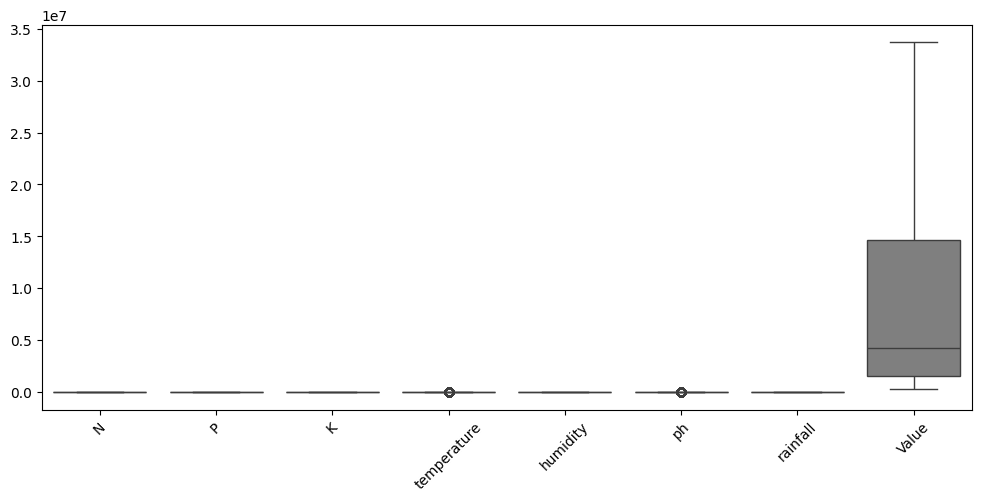

In [26]:
numeric_features = ["N","P","K","temperature","humidity","ph","rainfall","Value"]

# IQR-based outlier thresholds
Q1 = df_merged[numeric_features].quantile(0.25)
Q3 = df_merged[numeric_features].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers using IQR rule
df_clean = df_merged[~(
    (df_merged[numeric_features] < (Q1 - 1.5 * IQR)) |
    (df_merged[numeric_features] > (Q3 + 1.5 * IQR))
).any(axis=1)]

# Cleaned dataset size
len(df_clean)

# Crop counts after outlier removal
df_clean['Crop'].value_counts()

# Identify crops df_crop_raw removed due to outliers
all_crops = set(df_merged['Crop'].unique())
clean_crops = set(df_clean['Crop'].unique())
all_crops - clean_crops

# Visualize outlier distribution
import seaborn as sns
plt.figure(figsize=(12,5))
sns.boxplot(data=df_clean[numeric_features])
plt.xticks(rotation=45)
plt.show()

Machine Learning Pipeline

In [27]:
# Encode categorical crop label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_clean['Crop_encoded'] = label_encoder.fit_transform(df_clean['Crop'])

# Select features and target
X = df_clean[["N","P","K","temperature","humidity","ph","rainfall","Crop_encoded"]]
y = df_clean["Value"]   # FAO production value as target

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\manju varshikha\AppData\Local\Temp\ipykernel_15592\3492261206.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Crop_encoded'] = label_encoder.fit_transform(df_clean['Crop'])


REGRESSION MODEL 1: Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

REGRESSION MODEL 2: Random Forest Regressor

In [29]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=300, random_state=42
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

Model Evaluation

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Linear Regression Metrics
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_pred_lr)

# Random Forest Metrics
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_pred_rf)

print("----- Linear Regression Performance -----")
print("MAE:", lr_mae)
print("MSE:", lr_mse)
print("RMSE:", lr_rmse)
print("R²:", lr_r2)

print("\n----- Random Forest Performance -----")
print("MAE:", rf_mae)
print("MSE:", rf_mse)
print("RMSE:", rf_rmse)
print("R²:", rf_r2)

----- Linear Regression Performance -----
MAE: 5895725.275998821
MSE: 53112903805827.414
RMSE: 7287860.029242288
R²: 0.3791172122256574

----- Random Forest Performance -----
MAE: 1633778.5786295368
MSE: 7052179137161.867
RMSE: 2655593.9330330356
R²: 0.9175609629898505
